# Lecture 15: Regularización y reducción de dimensionalidad

En los modelos de clasificación y regresión, ocurre comúnmente que el error de predicción pueda crecer por el sobreajuste. Recordemos cómo se compone el error de un modelo:

$$ Err(x) = Bias^2 + Variance + IrreducibleError $$

Cuando un modelo se sobreajusta, se reduce el error de sesgo, pero aumenta el error de la varianza. Por ello, se entiende que el uso de un mayor número de datos no siempre es positivo: en algunos casos genera error en la predicción, sobre todo en casos de alta varianza entre los datos.

Una manera de reducir este error es por medio de la reducción de la complejidad del modelo. La idea principal aquí es cambiar sesgo por varianza: se aumenta un poco el primero para reducir un poco el segundo. Vamos a analizar dos maneras de hacerlo: regularización y reducción de dimensionalidad.



# 1. Regularización

La **regularización** busca disminuir la complejidad del modelo por medio de una **penalización a las variables menos importantes**. Para ello, hay tres tipos de metodologías para realizar esto: Lasso, Ridge y ElasticNet.

## 1.1. Modelos de regularización

### 1.1.1. Lasso

La metodología **Lasso** o **L1** reduce la complejidad a través de la **eliminación de variables** (o _features_) que no aportan bastante al modelo. El modelo matemático que lo soporta es el siguiente:

$$ \hat{\beta} = argmin \sum^n_{i=1} \left(y_i - \beta _0 - \sum ^p_{j=1} \beta_j x_{ij}  \right)^2 + \lambda\sum^p_{j=1} |\beta_j| $$

El lambda ($\lambda$) es el factor de penalización. A un mayor lambda, más variables van a ser llevadas a 0; a uno menor, menos variables van a ser llevadas a 0.

### 1.1.2. Ridge

La metodología **Ridge** o **L2** reduce la complejidad disminuyendo el impacto de ciertas variables (o _features_) en el modelo **sin eliminarlos**. El modelo matemático que lo soporta es el siguiente:

$$ \hat{\beta} = argmin \sum^n_{i=1} \left(y_i - \beta _0 - \sum ^p_{j=1} \beta_j x_{ij}  \right)^2 + \lambda\sum^p_{j=1} (\beta_j)^2 $$

El lambda ($\lambda$) es el factor de penalización. A un mayor lambda, más fuerte penalizará a las variables y las reducirá en su importancia; a uno menor, menos fuerte será la penalización de las variables. En todo caso, el uso de la potencia hace que, recursivamente, las variables no sean canceladas.

### 1.1.3. ElasticNet

La metodología **Elastic Net** reduce la complejidad **combinando los dos modelos anteriores** en un mismo modelo. El modelo matemático que lo soporta es el siguiente:

$$ L_{enet}(\hat{\beta}) = \frac{\sum^n_{i=1}(y_i - X^{'}_i\hat{\beta})^2}{2n} + \lambda \left(\frac{1-\alpha}{2}\sum^m_{j=1}\hat{\beta}^2_j + \alpha\sum^m_{j=1}|\hat{\beta}_j | \right) $$

Se tiene un parámetro adicional $\alpha$ ~ $[0, 1]$ que establece cuál es la importancia relativa de Lasso y Ridge dentro del modelo. En ese sentido, si $\alpha = 0$, Elastic Net se comportará como Ridge. Si $\alpha = 1$, se comportará como Lasso. Por tanto, **Elastic Net brinda todos los espectros lineales posibles de las combinaciones entre Lasso y Ridge**. 

Es decir,

* Tenemos una forma de probar tanto L1 como L2 sin perder información.
* Supera las limitaciones individuales de cada una de ellas.
* Si hace falta experiencia o conocimiento matemático de fondo, puede ser la opción preferente para probar la regularización.

## 1.2. Aplicación de los modelos de regularización

### Importe de los datos

Primero, carguemos los datos del ránkin de felicidad mundial.

In [1]:
import pandas as pd

data = pd.read_csv('./whr2017.csv')

print("La base de datos tiene {0} observaciones y {1} columnas.".format(data.shape[0], data.shape[1]))
data.head()

La base de datos tiene 155 observaciones y 12 columnas.


,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


Realicemos un análisis breve de las variables con `info()`.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     155 non-null    object 
 1   rank        155 non-null    int64  
 2   score       155 non-null    float64
 3   high        155 non-null    float64
 4   low         155 non-null    float64
 5   gdp         155 non-null    float64
 6   family      155 non-null    float64
 7   lifexp      155 non-null    float64
 8   freedom     155 non-null    float64
 9   generosity  155 non-null    float64
 10  corruption  155 non-null    float64
 11  dystopia    155 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 14.7+ KB


Como podemos observar, este método nos sirve para conocer sobre el nombre de la variable, el conteo de valores no nulos y el tipo de la variable. Puede complementar los otros métodos que hemos utilizado.

### Separación de la base de datos

Separemos los datos entre la matriz de covarianza (`X`) y el vector de la variable dependiente (`y`). Tras ello, separemos las bases de datos en aquellas de entrenamiento y testeo.

In [14]:
data.head()

,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [45]:
import pandas as pd

from sklearn.model_selection import train_test_split

# Separación de la base de datos en X e y
X = data[['gdp', 'family', 'lifexp', 'freedom', 'corruption', 'generosity', 'dystopia']]
y = data[['score']]

print("Número de observaciones de X: \t\t", X.shape[0])
print("Número de observaciones de y: \t\t", y.shape[0])

# Separación entre base de datos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

print("Número de observaciones de X_train: \t", X_train.shape[0])
print("Número de observaciones de X_val: \t", X_val.shape[0])
print("Número de observaciones de X_test: \t", X_test.shape[0])

Número de observaciones de X: 		 155
Número de observaciones de y: 		 155
Número de observaciones de X_train: 	 99
Número de observaciones de X_val: 	 25
Número de observaciones de X_test: 	 31


### Regularización

Realicemos el modelo de regularización. Sin embargo, hay varias cosas por establecer antes. Primero, es una buena práctica realizar una comparación de cada modelo con un modelo base. Para ello, vamos a establecer un modelo lineal como un modelo de base. Segundo, necesitamos una métrica para saber si un modelo es mejor que otro. En ese sentido, utilizaremos el error medio cuadrático, el cual se define como:

$$ ECM = \frac{1}{n}\sum^n_{i=1}(\hat{Y_i} - Y_i)^2 $$

Esta métrica es específica para regresiones lineales y predicción de variables numérica no categóricas.

En ese sentido, calculemos tres modelos:

1. Un modelo lineal.
2. Un modelo LASSO.
3. Un modelo RIDGE.
4. Un modelo Elastic Net.

Vamos uno por uno:

### 1. Modelo lineal

In [46]:
import pandas as pd
import sklearn

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

# Linear model
modelLinear = LinearRegression().fit(X_train, y_train)
y_predict_linear = modelLinear.predict(X_test)

# Evaluación del modelo
linear_loss = mean_squared_error(y_test, y_predict_linear)
print("Linear Loss: ", format(linear_loss, '.10f'))

Linear Loss:  0.0000000986


Veamos la importancia relativa de cada variable:

In [47]:
import pandas as pd
import numpy as np

pd.concat([pd.DataFrame(X.columns),\
    pd.DataFrame(np.transpose(modelLinear.coef_))], axis = 1)


,0,0
0,gdp,1.000068
1,family,0.999829
2,lifexp,1.000129
3,freedom,1.000206
4,corruption,0.999579
5,generosity,1.000143
6,dystopia,0.999943


In [48]:
modelLinear.coef_

array([[1.0000681 , 0.9998286 , 1.00012904, 1.00020553, 0.99957857,
        1.00014316, 0.99994316]])

> **Nota:** esto no demuestra el nivel de significancia y p-valor de las variables. Para ello, se utiliza la función `statsmodels.api.OLS`.

### 2. Modelo LASSO

In [90]:
from sklearn.linear_model import Lasso

# Inicial
print("Modelo sin optimizar:")

modelLasso = Lasso(0.2).fit(X_train, y_train)

y_predict_lasso = modelLasso.predict(X_test)
lasso_loss = mean_squared_error(y_test, y_predict_lasso)
print("Lasso Loss Test: ", format(lasso_loss, '.10f'))

Modelo sin optimizar:
Lasso Loss Test:  0.4704163701


In [87]:
# Optimización paramétrica (Hold-On)

import pandas as pd
import sklearn

from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

alphas = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
normalize = [True, False]

res = pd.DataFrame(columns = ['alpha', 'normalize', 'fit', 'mse'])

for fit in [True, False]:
    for n in normalize:
        for alpha in alphas:
            # Linear model
            modelLasso = Lasso(alpha = alpha, normalize = n).fit(X_train, y_train)
            y_predict_lasso = modelLasso.predict(X_val)

            # Evaluación del modelo
            lasso_loss = mean_squared_error(y_val, y_predict_lasso)
            #print(alpha, "Lasso Loss: ", format(lasso_loss, '.10f'))

            res = res.append({'alpha': alpha, 'fit': fit, 'normalize': n, 'mse': lasso_loss}, ignore_index = True)

res.sort_values('mse', ascending = True)



c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\juanm\AppData\Local\Temp\ipykernel_20140\1222931821.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'alpha': alpha, 'fit': fit, 'normalize': n

,alpha,normalize,fit,mse
0,1.000000e-08,True,True,6.773896e-08
42,1.000000e-08,True,False,6.773896e-08
1,1.000000e-07,True,True,6.787907e-08
43,1.000000e-07,True,False,6.787907e-08
44,1.000000e-06,True,False,6.953749e-08
...,...,...,...,...
55,3.000000e-01,True,False,8.476840e-01
56,4.000000e-01,True,False,8.476840e-01
57,5.000000e-01,True,False,8.476840e-01
59,7.000000e-01,True,False,8.476840e-01


In [83]:
from sklearn.linear_model import Lasso


print("="*64)

# Inicial
print("Modelo sin optimizar:")

modelLasso = Lasso().fit(X_train, y_train)
y_predict_lasso = modelLasso.predict(X_val)

# Evaluación del modelo
lasso_loss = mean_squared_error(y_val, y_predict_lasso)
print("Lasso Loss Validation: ", format(lasso_loss, '.10f'))

y_predict_lasso = modelLasso.predict(X_test)
lasso_loss = mean_squared_error(y_test, y_predict_lasso)
print("Lasso Loss Test: ", format(lasso_loss, '.10f'))
#===============================================================

print("\n")
print("="*64)

# Optimizado
print("Modelo optimizado:")
modelLasso_op = Lasso(alpha = res.iloc[0]["alpha"], normalize = res.iloc[0]["normalize"], fit_intercept = res.iloc[0]["fit"]).fit(X_train, y_train)
y_predict_lasso = modelLasso_op.predict(X_val)

# Evaluación del modelo
lasso_loss = mean_squared_error(y_val, y_predict_lasso)
print("Lasso Loss Validation: ", format(lasso_loss, '.10f'))

y_predict_lasso = modelLasso_op.predict(X_test)
lasso_loss = mean_squared_error(y_test, y_predict_lasso)
print("Lasso Loss Test: ", format(lasso_loss, '.10f'))


Modelo sin optimizar:
Lasso Loss Validation:  0.8476839826
Lasso Loss Test:  1.3022002578


Modelo optimizado:
Lasso Loss Validation:  0.0000000677
Lasso Loss Test:  0.0000001070


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [73]:
print("Lasso Loss: ", format(res['mse'][0], '.10f'))

Lasso Loss:  0.0000000677


<AxesSubplot:xlabel='alpha'>

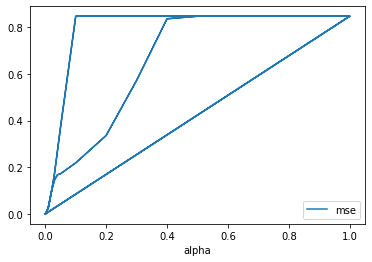

In [69]:
res.plot(x = 'alpha', y = 'mse')

Revisemos también los coeficientes de LASSO:

In [91]:
import pandas as pd
import numpy as np

pd.concat([pd.DataFrame(X.columns),\
    pd.DataFrame(np.transpose(modelLasso.coef_))], axis = 1)

,0,0
0,gdp,1.159710
1,family,0.000000
2,lifexp,0.000000
3,freedom,0.000000
4,corruption,0.000000
5,generosity,0.000000
6,dystopia,0.336925


In [92]:
modelLasso.coef_

array([1.1597103 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33692495])

### 3. Modelo Ridge

In [94]:
import pandas as pd
import sklearn

from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Linear model
modelRidge = Ridge(alpha = 1).fit(X_train, y_train)
y_predict_ridge = modelRidge.predict(X_test)

# Evaluación del modelo
ridge_loss = mean_squared_error(y_test, y_predict_ridge)
print("Ridge Loss: ", format(ridge_loss, '.10f'))

Ridge Loss:  0.0081559318


Revisemos los coeficientes de RIDGE:

In [95]:
import pandas as pd
import numpy as np

pd.concat([pd.DataFrame(X.columns),\
    pd.DataFrame(np.transpose(modelRidge.coef_))], axis = 1)

,0,0
0,gdp,1.117092
1,family,0.956861
2,lifexp,0.808692
3,freedom,0.845461
4,corruption,0.632675
5,generosity,0.675598
6,dystopia,0.955558


### 4. Elastic Net

In [96]:
import pandas as pd
import sklearn

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

# Linear model
modelEN = ElasticNet().fit(X_train, y_train)
y_predict_EN = modelEN.predict(X_test)

# Evaluación del modelo
en_loss = mean_squared_error(y_test, y_predict_EN)
print("Ridge Loss: ", format(en_loss, '.10f'))

Ridge Loss:  1.3022002578


Revisemos los coeficientes de EN:

In [97]:
import pandas as pd
import numpy as np

pd.concat([pd.DataFrame(X.columns),\
    pd.DataFrame(np.transpose(modelEN.coef_))], axis = 1)

,0,0
0,gdp,0.0
1,family,0.0
2,lifexp,0.0
3,freedom,0.0
4,corruption,0.0
5,generosity,0.0
6,dystopia,0.0


In [69]:
modelEN.coef_

array([0., 0., 0., 0., 0., 0., 0.])

### Optimización paramétrica

Sabemos que podemos hacerlo mejor: vamos a ver cómo hacerlo.

In [104]:
import pandas as pd
import sklearn
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Modelos
reg = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# Parámetros de los modelos
params = {
    'LinearRegression': {
        'fit_intercept': [True, False],
        'normalize': [True, False]
    },
    'Lasso': {
        'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0],
        'fit_intercept': [True, False],
        'normalize': [True, False]
    },
    'Ridge': {
        'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0],
        'fit_intercept': [True, False],
        'normalize': [True, False]
    },
    'ElasticNet': {
        'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
}

best_score = 999
best_model = None

for name, reg in reg.items():

    print("="*64)
    print(name, reg)
    print("="*64)

    grid_reg = GridSearchCV(reg, params[name], cv = 3).fit(X_train, y_train.values.ravel())
    score = np.abs(grid_reg.best_score_)

    

    if score < best_score:
        best_score = score
        best_model = grid_reg.best_estimator_
        


LinearRegression LinearRegression()


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous be

0.9999999324653214
Lasso Lasso()


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

0.9999999245149405
Ridge Ridge()


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as fol

0.9999999324653214
ElasticNet ElasticNet()


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_r

0.9999999245149405


c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\juanm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

# 2. Análisis de Componentes Principales

## 2.1. La metodología

El **análisis de componentes principales** es un método que captura la contribución a la varianza de cada una de las variables para reducir su dimensionalidad en `n` componentes. Es decir, PCA intenta combinar las variables del modelo en unos _features_ artificiales que mantengan la misma información, pero en una dimensionalidad menor.

<center><image src = https://miro.medium.com/max/1400/1*ba0XpZtJrgh7UpzWcIgZ1Q.jpeg> </center>

El algoritmo que utiliza es el siguiente:

* Calcula la matriz de covarianzas, estipulando las relaciones entre variables.
* Halla los _eigenvalues_ (vectores y valores propios) de la matriz, para medir la fuerza y variabilidad de las relaciones
* Se ordenan para escoger los valores con mayor variabilidad, ya que estos son los que tienen mayor información.

## 2.2. Implementación

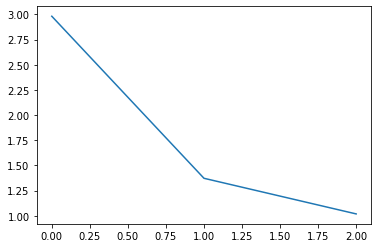

In [105]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler # Standarization tool
from sklearn.model_selection import train_test_split # Separation of the dataset

# Estandarización de los valores
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Entrenamiento
pca = PCA(n_components = 3) 
pca.fit(X_train)

plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_)
plt.show()


Ahora esto nos entrega unos datos para la predicción, no es el modelo de predicción mismo. Así que apliquemos un modelo lineal:

In [107]:
from sklearn.linear_model import LinearRegression

dt_train = pca.transform(X_train)
dt_test = pca.transform(X_test)

modelLinear = LinearRegression().fit(dt_train, y_train)
y_predict_linear = modelLinear.predict(dt_test)

# Evaluación del modelo
linear_loss = mean_squared_error(y_test, y_predict_linear)
print("Linear Loss: ", format(linear_loss, '.10f'))


Linear Loss:  0.0476596317
